smooth     M=  50   MSE=0.073211   MAE=0.206209
smooth     M= 100   MSE=0.037500   MAE=0.146185
smooth     M= 200   MSE=0.003654   MAE=0.046571
smooth     M= 300   MSE=0.000423   MAE=0.015975
smooth     M= 400   MSE=0.000141   MAE=0.009167
smooth     M= 500   MSE=0.000070   MAE=0.006400
smooth     M= 600   MSE=0.000050   MAE=0.005382
textured   M=  50   MSE=0.017756   MAE=0.105444
textured   M= 100   MSE=0.014255   MAE=0.095968
textured   M= 200   MSE=0.002000   MAE=0.035190
textured   M= 300   MSE=0.002278   MAE=0.038092
textured   M= 400   MSE=0.001605   MAE=0.031892
textured   M= 500   MSE=0.001512   MAE=0.031116
textured   M= 600   MSE=0.001401   MAE=0.029822


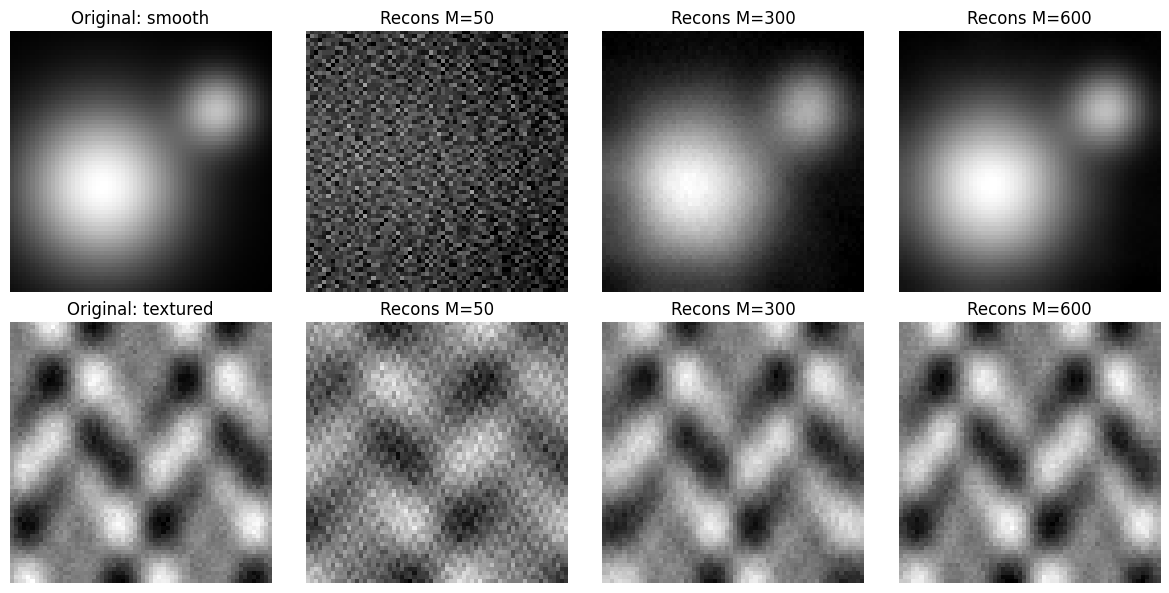

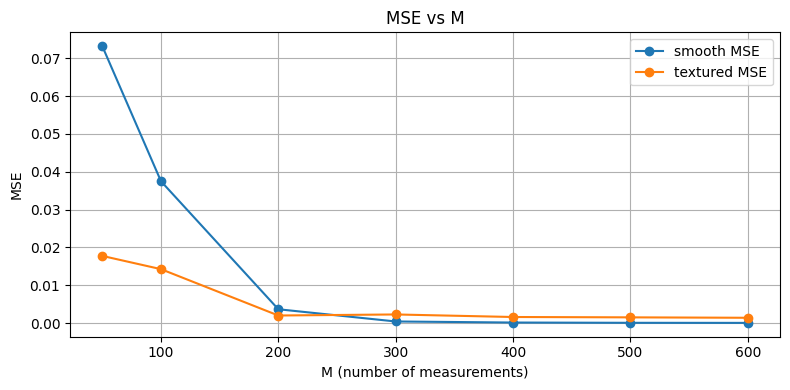

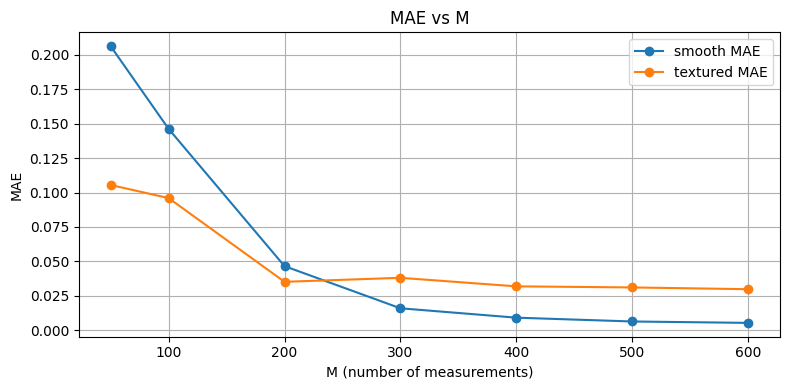


Summary for smooth:
  M=  50  MSE=7.321124e-02  MAE=2.062087e-01
  M= 100  MSE=3.749977e-02  MAE=1.461851e-01
  M= 200  MSE=3.654305e-03  MAE=4.657108e-02
  M= 300  MSE=4.230108e-04  MAE=1.597504e-02
  M= 400  MSE=1.414558e-04  MAE=9.167114e-03
  M= 500  MSE=6.968466e-05  MAE=6.400175e-03
  M= 600  MSE=4.990045e-05  MAE=5.382107e-03

Summary for textured:
  M=  50  MSE=1.775617e-02  MAE=1.054439e-01
  M= 100  MSE=1.425547e-02  MAE=9.596841e-02
  M= 200  MSE=2.000219e-03  MAE=3.519046e-02
  M= 300  MSE=2.278141e-03  MAE=3.809158e-02
  M= 400  MSE=1.604633e-03  MAE=3.189189e-02
  M= 500  MSE=1.512172e-03  MAE=3.111612e-02
  M= 600  MSE=1.401274e-03  MAE=2.982189e-02

Saved reconstructions to /mnt/data/cs_recons


In [ ]:
# Python code to perform the compressive sensing experiment described.
# It generates two grayscale images (smooth and textured), takes random ±1 projections,
# reconstructs using Basis Pursuit (min ||alpha||_1 s.t. A alpha = y) where alpha are 2D-DCT coefficients,
# and reports MSE/MAE versus number of measurements M.
# This runs in the notebook environment and will display images and plots.
# If scipy or cvxpy are not installed, the code will try to indicate that and abort gracefully.

import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
import cvxpy as cp
from skimage import util

# Settings
n_side = 64              # image size: n_side x n_side -> N = n_side**2
N = n_side * n_side
rng = np.random.default_rng(0)

# Create two test images
x_coords = np.linspace(-1, 1, n_side)
X, Y = np.meshgrid(x_coords, x_coords)

# Smooth image: a few low-frequency gaussian blobs (smooth surfaces)
smooth = np.exp(-((X+0.3)**2 + (Y-0.2)**2) / (2*(0.45**2)))
smooth += 0.7 * np.exp(-((X-0.6)**2 + (Y+0.4)**2) / (2*(0.2**2)))
smooth = smooth / smooth.max()

# Textured image: sum of sinusoids + small-scale noise
textured = 0.5*(np.sin(6*X) * np.cos(6*Y)) + 0.3*(np.sin(12*X) * np.sin(8*Y))
textured += 0.2 * rng.normal(scale=0.2, size=(n_side, n_side))
textured = (textured - textured.min())
textured = textured / textured.max()

images = {
    "smooth": smooth,
    "textured": textured
}

# Utility: 2D DCT and inverse 2D DCT (orthonormal)
def dct2(block):
    return fftpack.dct(fftpack.dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return fftpack.idct(fftpack.idct(block.T, norm='ortho').T, norm='ortho')


# Build inverse-2D-DCT basis matrix Psi (size N x N) where x = Psi @ alpha
# Each column of Psi is vec(idct2(E_i)) where E_i is basis vector of DCT coords.
def build_idct_basis(n_side):
    N = n_side * n_side
    Psi = np.zeros((N, N), dtype=np.float32)
    for i in range(N):
        e = np.zeros((n_side, n_side), dtype=float)
        e.flat[i] = 1.0
        img = idct2(e)
        Psi[:, i] = img.flatten()
    return Psi

Psi = build_idct_basis(n_side)  # N x N

# Experiment settings: different numbers of measurements M to test
M_list = np.array([50, 100, 200, 300, 400, 500, 600])
M_list = M_list[M_list <= N]  # ensure M <= N

# Choose projection matrix distribution: entries +/- sqrt(1/M)
def make_projection_matrix(M, N, rng):
    P = rng.choice([-1.0, 1.0], size=(M, N))
    P = P * np.sqrt(1.0 / M)
    return P

results = {}

for name, img in images.items():
    x = img.flatten().astype(float)
    # Normalize to [0,1]
    x = (x - x.min())
    if x.max() > 0:
        x = x / x.max()
    # Compute true DCT coefficients alpha_true
    alpha_true = dct2(img).flatten()
    results[name] = {"Ms": [], "MSE": [], "MAE": [], "recons": {}, "P_list": []}

    for M in M_list:
        P = make_projection_matrix(M, N, rng)
        # Measurements: y = P x
        y = P @ x

        # Measurement matrix in the DCT domain: A = P @ Psi  (size M x N)
        A = P @ Psi

        # Basis Pursuit in alpha: minimize ||alpha||_1 s.t. A alpha = y
        alpha = cp.Variable(N)
        objective = cp.Minimize(cp.norm1(alpha))
        constraints = [A @ alpha == y]
        prob = cp.Problem(objective, constraints)

        # Solve (use SCS as broadly available solver)
        try:
            prob.solve(solver=cp.SCS, verbose=False, eps=1e-3, max_iters=5000)
        except Exception as e:
            print(f"Solver failed for {name} M={M} with error: {e}")
            break

        alpha_rec = alpha.value
        if alpha_rec is None:
            print(f"Solver returned no solution for {name}, M={M}.")
            break

        x_rec = (Psi @ alpha_rec).reshape((n_side, n_side))
        # Clip to [0,1]
        x_rec = np.clip(x_rec, 0, 1)

        mse = np.mean((x_rec.flatten() - x)**2)
        mae = np.mean(np.abs(x_rec.flatten() - x))

        results[name]["Ms"].append(M)
        results[name]["MSE"].append(mse)
        results[name]["MAE"].append(mae)
        results[name]["recons"][M] = x_rec
        results[name]["P_list"].append(P)

        print(f"{name:9s}  M={M:4d}   MSE={mse:.6f}   MAE={mae:.6f}")

# Display original and example reconstructions for a mid M, and plot error vs M
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, (name, info) in enumerate(results.items()):
    ax = axes[i, 0]
    ax.imshow(images[name], cmap='gray', vmin=0, vmax=1)
    ax.set_title(f"Original: {name}")
    ax.axis('off')

    # show reconstructions for first, middle, last M
    Ms = info["Ms"]
    idxs = [0, len(Ms)//2, len(Ms)-1]
    for j, idx in enumerate(idxs):
        M = Ms[idx]
        ax = axes[i, j+1]
        ax.imshow(info["recons"][M], cmap='gray', vmin=0, vmax=1)
        ax.set_title(f"Recons M={M}")
        ax.axis('off')

plt.tight_layout()

# Plot MSE and MAE vs M for both images
plt.figure(figsize=(8,4))
for name, info in results.items():
    plt.plot(info["Ms"], info["MSE"], marker='o', label=f"{name} MSE")
plt.xlabel("M (number of measurements)")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.title("MSE vs M")
plt.tight_layout()

plt.figure(figsize=(8,4))
for name, info in results.items():
    plt.plot(info["Ms"], info["MAE"], marker='o', label=f"{name} MAE")
plt.xlabel("M (number of measurements)")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.title("MAE vs M")
plt.tight_layout()

# Show final plots
plt.show()

# Summarize numeric results
for name, info in results.items():
    print(f"\nSummary for {name}:")
    for M, mse, mae in zip(info["Ms"], info["MSE"], info["MAE"]):
        print(f"  M={M:4d}  MSE={mse:.6e}  MAE={mae:.6e}")

# Save example reconstructions to disk for download if needed
import os
out_dir = "/mnt/data/cs_recons"
os.makedirs(out_dir, exist_ok=True)
for name, info in results.items():
    for M, rec in info["recons"].items():
        fname = os.path.join(out_dir, f"{name}_recon_M{M}.png")
        plt.imsave(fname, rec, cmap='gray', vmin=0, vmax=1)

print(f"\nSaved reconstructions to {out_dir}")




In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import numpy as np

# --- 1. Wczytanie danych ---
(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = cifar10.load_data()

print("Oryginalne kształty:")
print("x_train_cifar:", x_train_cifar.shape)
print("x_test_cifar:", x_test_cifar.shape)

# --- 2. Konwersja do skali szarości ---
# Średnia ważona kanałów RGB (standard NTSC)
x_train_gray_cifar = np.dot(x_train_cifar[..., :3], [0.2989, 0.5870, 0.1140])
x_test_gray_cifar = np.dot(x_test_cifar[..., :3], [0.2989, 0.5870, 0.1140])

# --- 4. (Opcjonalnie) ograniczenie rozmiaru zbioru dla słabszego sprzętu ---
# np. tylko 10% danych:
limit = 0.1
n_train = int(len(x_train_gray_cifar) * limit)
n_test = int(len(x_test_gray_cifar) * limit)

x_train_gray_cifar = x_train_gray_cifar[:n_train]
y_train_cifar = y_train_cifar[:n_train]
x_test_gray_cifar = x_test_gray_cifar[:n_test]
y_test_cifar = y_test_cifar[:n_test]


x_train_gray_cifar = tf.image.resize(x_train_gray_cifar[..., np.newaxis], [256, 256]).numpy()
x_test_gray_cifar = tf.image.resize(x_test_gray_cifar[..., np.newaxis], [256, 256]).numpy()

# --- 3. Normalizacja ---
x_train_gray_cifar = x_train_gray_cifar.astype('float32') / 255.0
x_test_gray_cifar = x_test_gray_cifar.astype('float32') / 255.0


print("Po konwersji i ograniczeniu:")
print("x_train_gray_cifar:", x_train_gray_cifar.shape)
print("x_test_gray_cifar:", x_test_gray_cifar.shape)

Oryginalne kształty:
x_train_cifar: (50000, 32, 32, 3)
x_test_cifar: (10000, 32, 32, 3)
Po konwersji i ograniczeniu:
x_train_gray_cifar: (5000, 256, 256, 1)
x_test_gray_cifar: (1000, 256, 256, 1)


In [3]:
from tensorflow.keras.datasets import fashion_mnist


# --- 1. Wczytanie danych ---
(x_train_fmnist, y_train_fmnist), (x_test_fmnist, y_test_fmnist) = fashion_mnist.load_data()

print("Oryginalne kształty:")
print("x_train_fmnist:", x_train_fmnist.shape)
print("x_test_fmnist:", x_test_fmnist.shape)

# --- 4. (Opcjonalnie) ograniczenie rozmiaru zbioru dla słabszego sprzętu ---
# np. tylko 10% danych:
limit = 0.1
n_train = int(len(x_train_fmnist) * limit)
n_test = int(len(x_test_fmnist) * limit)

x_train_gray_fmnist = x_train_fmnist[:n_train]
y_train_fmnist = y_train_fmnist[:n_train]
x_test_gray_fmnist = x_test_fmnist[:n_test]
y_test_fmnist = y_test_fmnist[:n_test]


x_train_gray_fmnist = tf.image.resize(x_train_gray_fmnist[..., np.newaxis], [256, 256]).numpy()
x_test_gray_fmnist = tf.image.resize(x_test_gray_fmnist[..., np.newaxis], [256, 256]).numpy()

# --- 3. Normalizacja ---
x_train_gray_fmnist = x_train_gray_fmnist.astype('float32') / 255.0
x_test_gray_fmnist = x_test_gray_fmnist.astype('float32') / 255.0


print("Po konwersji i ograniczeniu:")
print("x_train_gray_fmnist:", x_train_gray_fmnist.shape)
print("x_test_gray_fmnist:", x_test_gray_fmnist.shape)

Oryginalne kształty:
x_train_fmnist: (60000, 28, 28)
x_test_fmnist: (10000, 28, 28)
Po konwersji i ograniczeniu:
x_train_gray_fmnist: (6000, 256, 256, 1)
x_test_gray_fmnist: (1000, 256, 256, 1)


In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256,256,1)), # -> (254,254,32)
    tf.keras.layers.MaxPooling2D(2,2), # -> (127,127,32)
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(127,127,64)), # -> (125,125,64)
    tf.keras.layers.MaxPooling2D(2,2), # -> (62,62,64)
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(62,62,128)), # -> (60,60,128)
    tf.keras.layers.MaxPooling2D(2,2), # -> (30,30,128)
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(30,30,128)), # -> (28,28,128)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,086,730 (49.92 MB)

 Trainable params: 13,086,730 (49.92 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
def build_model():
    model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256,256,1)), # -> (254,254,32)
      tf.keras.layers.MaxPooling2D(2,2), # -> (127,127,32)
      tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(127,127,64)), # -> (125,125,64)
      tf.keras.layers.MaxPooling2D(2,2), # -> (62,62,64)
      tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(62,62,128)), # -> (60,60,128)
      tf.keras.layers.MaxPooling2D(2,2), # -> (30,30,128)
      tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(30,30,128)), # -> (28,28,128)
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [7]:
from sklearn.model_selection import KFold

In [4]:
#wyniki dla CIFAR10

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cnn_cv_scores_cifar = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train_gray_cifar), 1):
  print(f"Fold {fold}/5...")

  X_train_fold = x_train_gray_cifar[train_idx]
  y_train_fold = y_train_cifar[train_idx]
  X_val_fold = x_train_gray_cifar[val_idx]
  y_val_fold = y_train_cifar[val_idx]

  model = build_model()

  history = model.fit(
      X_train_fold, y_train_fold,
      epochs=10,
      batch_size=64,
      validation_data=(X_val_fold, y_val_fold),
      verbose=0)

  _, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)

  cnn_cv_scores_cifar.append(val_acc)
  print(f"  Validation Accuracy: {val_acc:.4f}")

  # Czyszczenie pamięci
  tf.keras.backend.clear_session()


print(f"\nCNN CV Mean: {np.mean(cnn_cv_scores_cifar):.4f} (+/- {np.std(cnn_cv_scores_cifar):.4f})")

Fold 1/5...
  Validation Accuracy: 0.3990
Fold 2/5...
  Validation Accuracy: 0.2790
Fold 3/5...
  Validation Accuracy: 0.3980
Fold 4/5...
  Validation Accuracy: 0.4170
Fold 5/5...
  Validation Accuracy: 0.3460

CNN CV Mean: 0.3678 (+/- 0.0503)


In [8]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cnn_cv_scores_fmnist = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train_gray_fmnist), 1):
  print(f"Fold {fold}/5...")

  X_train_fold = x_train_gray_fmnist[train_idx]
  y_train_fold = y_train_fmnist[train_idx]
  X_val_fold = x_train_gray_fmnist[val_idx]
  y_val_fold = y_train_fmnist[val_idx]

  model = build_model()

  history = model.fit(
      X_train_fold, y_train_fold,
      epochs=10,
      batch_size=64,
      validation_data=(X_val_fold, y_val_fold),
      verbose=0)

  _, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)

  cnn_cv_scores_fmnist.append(val_acc)
  print(f"  Validation Accuracy: {val_acc:.4f}")

  # Czyszczenie pamięci
  tf.keras.backend.clear_session()


print(f"\nCNN CV Mean: {np.mean(cnn_cv_scores_fmnist):.4f} (+/- {np.std(cnn_cv_scores_fmnist):.4f})")

Fold 1/5...
  Validation Accuracy: 0.8658
Fold 2/5...
  Validation Accuracy: 0.8683
Fold 3/5...
  Validation Accuracy: 0.8575
Fold 4/5...
  Validation Accuracy: 0.8717
Fold 5/5...
  Validation Accuracy: 0.8683

CNN CV Mean: 0.8663 (+/- 0.0048)


In [5]:
import numpy as np

M = 1000
rng = np.random.default_rng(0)

# --- Przygotowanie danych ---
X_cifar = x_train_gray_cifar.reshape(len(x_train_gray_cifar), -1)  # (N_train, N_pixeli)
X_test_cifar = x_test_gray_cifar.reshape(len(x_test_gray_cifar), -1)

N = X_cifar.shape[1]  # oryginalny wymiar

# --- Budowa macierzy rzutowania ---
P = rng.choice([-1.0, 1.0], size=(M, N)) * np.sqrt(1.0 / M)

# --- Rzutowanie ---
X_proj_cifar = X_cifar @ P.T
X_test_proj_cifar = X_test_cifar @ P.T

print("Kształty po rzucie:")
print("X_proj:", X_proj_cifar.shape)
print("X_test_proj:", X_test_proj_cifar.shape)

# --- Zbiór MCIFAR10 ---
MCIFAR10_train = (X_proj_cifar, y_train_cifar)
MCIFAR10_test = (X_test_proj_cifar, y_test_cifar)


Kształty po rzucie:
X_proj: (5000, 1000)
X_test_proj: (1000, 1000)


In [10]:
import numpy as np

M = 1000
rng = np.random.default_rng(0)

# --- Przygotowanie danych ---
X_fmnist = x_train_gray_fmnist.reshape(len(x_train_gray_fmnist), -1)  # (N_train, N_pixeli)
X_test_fmnist = x_test_gray_fmnist.reshape(len(x_test_gray_fmnist), -1)

N = X_fmnist.shape[1]  # oryginalny wymiar

# --- Budowa macierzy rzutowania ---
P = rng.choice([-1.0, 1.0], size=(M, N)) * np.sqrt(1.0 / M)

# --- Rzutowanie ---
X_proj_fmnist = X_fmnist @ P.T
X_test_proj_fmnist = X_test_fmnist @ P.T

print("Kształty po rzucie:")
print("X_proj:", X_proj_fmnist.shape)
print("X_test_proj:", X_test_proj_fmnist.shape)

# --- Zbiór MCIFAR10 ---
MFMNIST_train = (X_proj_fmnist, y_train_fmnist)
MFMNIST_test = (X_test_proj_fmnist, y_test_fmnist)


Kształty po rzucie:
X_proj: (6000, 1000)
X_test_proj: (1000, 1000)


In [11]:
def build_mlp_model():
  mlp = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(M,)),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

  mlp.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return mlp

In [12]:
mlp = build_mlp_model()
mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       512,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 678,026 (2.59 MB)

 Trainable params: 678,026 (2.59 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
mlp_cv_scores_cifar = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_proj_cifar), 1):
    print(f"Fold {fold}/5...")

    X_train_fold = X_proj_cifar[train_idx]
    y_train_fold = y_train_cifar[train_idx]
    X_val_fold = X_proj_cifar[val_idx]
    y_val_fold = y_train_cifar[val_idx]

    mlp = build_mlp_model()

    history = mlp.fit(
        X_train_fold, y_train_fold,
        epochs=10,
        batch_size=64,
        validation_data=(X_val_fold, y_val_fold),
        verbose=0)

    _, val_acc = mlp.evaluate(X_val_fold, y_val_fold, verbose=0)
    mlp_cv_scores_cifar.append(val_acc)
    print(f"  Validation Accuracy: {val_acc:.4f}")

    tf.keras.backend.clear_session()

print(f"\nMLP CV Mean: {np.mean(mlp_cv_scores_cifar):.4f} (+/- {np.std(mlp_cv_scores_cifar):.4f})")

Fold 1/5...
  Validation Accuracy: 0.2270
Fold 2/5...
  Validation Accuracy: 0.2440
Fold 3/5...
  Validation Accuracy: 0.2740
Fold 4/5...
  Validation Accuracy: 0.2250
Fold 5/5...
  Validation Accuracy: 0.2360

MLP CV Mean: 0.2412 (+/- 0.0177)


In [13]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
mlp_cv_scores_fmnist = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_proj_fmnist), 1):
    print(f"Fold {fold}/5...")

    X_train_fold = X_proj_fmnist[train_idx]
    y_train_fold = y_train_fmnist[train_idx]
    X_val_fold = X_proj_fmnist[val_idx]
    y_val_fold = y_train_fmnist[val_idx]

    mlp = build_mlp_model()

    history = mlp.fit(
        X_train_fold, y_train_fold,
        epochs=10,
        batch_size=64,
        validation_data=(X_val_fold, y_val_fold),
        verbose=0)

    _, val_acc = mlp.evaluate(X_val_fold, y_val_fold, verbose=0)
    mlp_cv_scores_fmnist.append(val_acc)
    print(f"  Validation Accuracy: {val_acc:.4f}")

    tf.keras.backend.clear_session()

print(f"\nMLP CV Mean: {np.mean(mlp_cv_scores_fmnist):.4f} (+/- {np.std(mlp_cv_scores_fmnist):.4f})")

Fold 1/5...
  Validation Accuracy: 0.8267
Fold 2/5...
  Validation Accuracy: 0.8375
Fold 3/5...
  Validation Accuracy: 0.8317
Fold 4/5...
  Validation Accuracy: 0.8142
Fold 5/5...
  Validation Accuracy: 0.8442

MLP CV Mean: 0.8308 (+/- 0.0102)
